## Top

In [4]:
from astrometry.util.fits import fits_table, merge_tables
from astrometry.libkd.spherematch import match_radec
from astrometry.util.plotutils import plothist
from astrometry.util.starutil_numpy import arcsec_between
import numpy as np
import pylab as plt
from collections import Counter
from glob import glob
import pickle

from astrometry.util.util import Tan
from astrometry.util.util import Sip
import fitsio

In [15]:
ignore_bits = [
    12,   # "fullsample"
    21,   # "source"
]
flag_mask = ~np.uint32(sum([1 << b for b in ignore_bits]))
flag_mask_source = np.uint32(1 << 21)
'0x%x' % flag_mask

'0xffdfefff'

## Read headers for metadata

In [64]:
fns = glob('cosmo/staging/spherex/qr/level2/2025W*/l2b-*/*/*.fits')
fns.sort()
len(fns)

86791

In [65]:
fns[0]

'cosmo/staging/spherex/qr/level2/2025W18_2B/l2b-v12-2025-164/1/level2_2025W18_2B_0001_1D1_spx_l2b-v12-2025-164.fits'

In [11]:
fn = fns[0]
wcs = Sip(fn, 1)

In [12]:
wcs.shape

(2040.0, 2040.0)

In [15]:
T_old = fits_table('spherex-meta.fits')
len(T_old)

75889

In [17]:
old_fns = set(T_old.filename)
fns = [fn for fn in fns if fn not in old_fns]
len(fns)

10902

In [18]:
T = fits_table()
T.filename = np.array(fns)
T.radec_corners = np.zeros((len(T), 8))
T.ra = np.zeros(len(T))
T.dec = np.zeros(len(T))
T.width = np.zeros(len(T))
T.height = np.zeros(len(T))
T.cd11 = np.zeros(len(T))
T.cd12 = np.zeros(len(T))
T.cd21 = np.zeros(len(T))
T.cd22 = np.zeros(len(T))
T.mjd = np.zeros(len(T))
T.exptime = np.zeros(len(T))
T.detector = np.zeros(len(T))
# OBSID   = '2025W18_2B_0001_1'  / Observation ID
# EXPIDN  =      202518202000111 / Integer Exposure ID
T.obsid = np.zeros(len(T), 'U17')
T.expidn = np.zeros(len(T), int)

In [20]:
inext = 64
for i,fn in enumerate(fns):
    if i >= inext:
        print(i)
        inext *= 2
    wcs = Sip(fn, 1)
    h,w = wcs.shape
    T.width[i] = w
    T.height[i] = h
    T.cd11[i] = wcs.cd[0]
    T.cd12[i] = wcs.cd[1]
    T.cd21[i] = wcs.cd[2]
    T.cd22[i] = wcs.cd[3]
    r,d = wcs.pixelxy2radec(w/2 + 0.5, h/2 + 0.5)
    T.ra[i] = r
    T.dec[i] = d
    for j,(x,y) in enumerate([(1,1), (w,1), (w,h), (1,h)]):
        r,d = wcs.pixelxy2radec(x, y)
        T.radec_corners[i, j*2: (j+1)*2] = r,d
    hdr = fitsio.read_header(fn, ext=1)
    T.detector[i] = hdr['DETECTOR']
    T.obsid[i] = hdr['OBSID']
    T.expidn[i] = hdr['EXPIDN']
    T.mjd[i] = hdr['MJD-AVG']
    T.exptime[i] = hdr['XPOSURE']

64
128
256
512
1024
2048
4096
8192


In [23]:
T_merge = merge_tables([T_old, T])
T_new = T
T = T_merge

In [24]:
T.writeto('spherex-meta.fits')

In [2]:
# Resume
T = fits_table('spherex-meta.fits')

In [27]:
len(T)

86791

In [3]:
T.mjd.max() - T.mjd.min()

27.990072627995687

In [4]:
detector_color={1:'purple',2:'b', 3:'g', 4:'y', 5:'orange', 6:'r'}

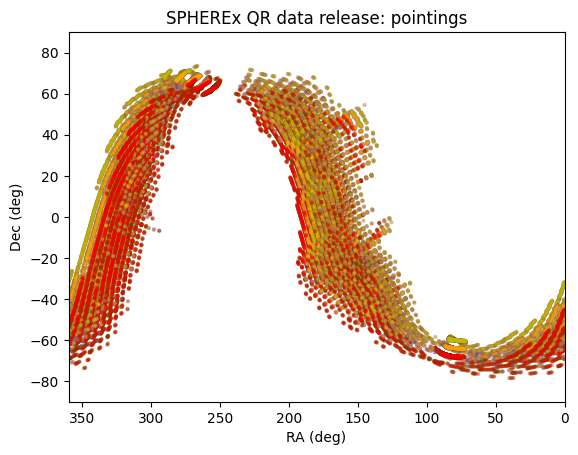

In [5]:
plt.scatter(T.ra, T.dec, c=[detector_color[d] for d in T.detector], s=4, alpha=0.2);
plt.xlim(360,0)
plt.ylim(-90, +90)
plt.title('SPHEREx QR data release: pointings')
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')
plt.savefig('radec.png');

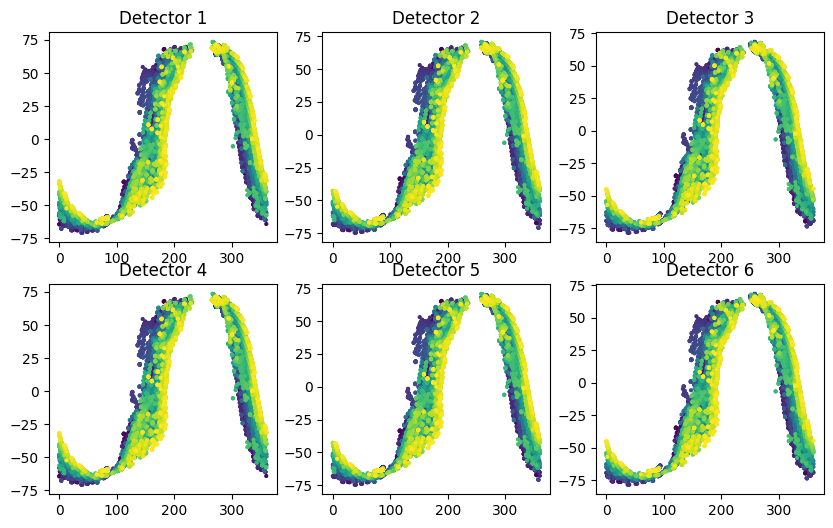

In [6]:
plt.figure(figsize=(10,6))
for i,d in enumerate(np.unique(T.detector)):
    plt.subplot(2,3, i+1)
    I = np.flatnonzero(T.detector == d)
    plt.scatter(T.ra[I], T.dec[I], c=T.mjd[I], s=4);
    plt.title('Detector %i' % d)
    


In [7]:
from astrometry.util.util import anwcs_create_allsky_hammer_aitoff2

In [9]:
H,W = 500, 1000
hammer = anwcs_create_allsky_hammer_aitoff2(0, 0, W, H)

In [10]:
xx,yy = np.meshgrid(np.arange(W), np.arange(H))
ok,rr,dd = hammer.pixelxy2radec(xx.ravel(), yy.ravel())

In [28]:
((2040 * 6.15) / 3600.)**2

12.145225

In [18]:
# Approximate each SPHEREx exposure as a circle with the same sky area
R = ((2040 * 6.15) / 3600.) / np.sqrt(np.pi)

15.0


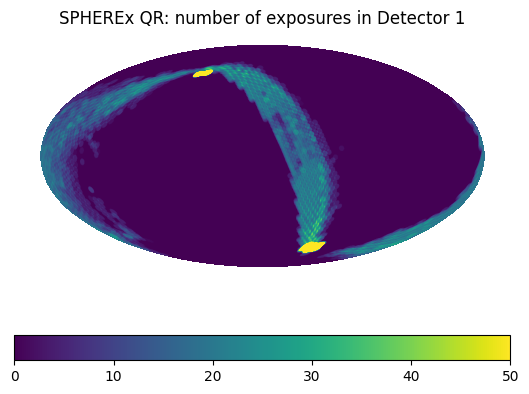

In [38]:
Iok = np.flatnonzero(ok)
for detector in range(1, 6+1):
    count = np.zeros((H,W), np.float32)
    Id = np.flatnonzero(T.detector == detector)
    I = match_radec(rr[ok], dd[ok], T.ra[Id], T.dec[Id], R, indexlist=True)
    count.flat[Iok] += np.array([(len(ii) if ii else 0) for ii in I])
    break
count.flat[~ok] = np.nan
print(np.median(count[count>0]))
plt.imshow(count, vmin=0, vmax=50);
plt.colorbar(orientation='horizontal');
plt.axis('off')
plt.title('SPHEREx QR: number of exposures in Detector 1');
plt.savefig('spherex-nexp.png');
#plt.xlabel('RA')
#plt.ylabel('Dec')

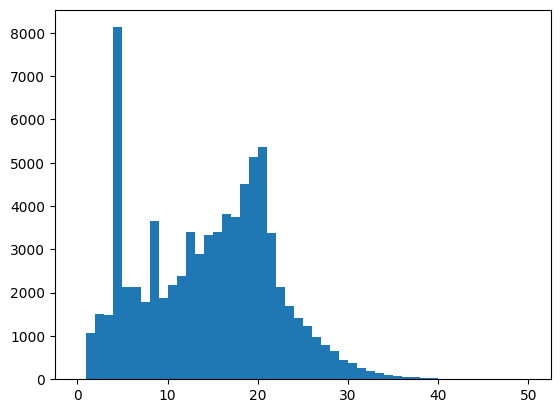

In [41]:
plt.hist(count[count>0], range=(0, 50), bins=50);

In [19]:
R

1.9662006986639307

In [7]:
len(np.unique(T.obsid))

14838

In [7]:
I = np.argsort(T.mjd)
T.mjd[I]

array([60796.51169075, 60796.51169076, 60796.51169076, ...,
       60824.50176338, 60824.50176338, 60824.50176338])

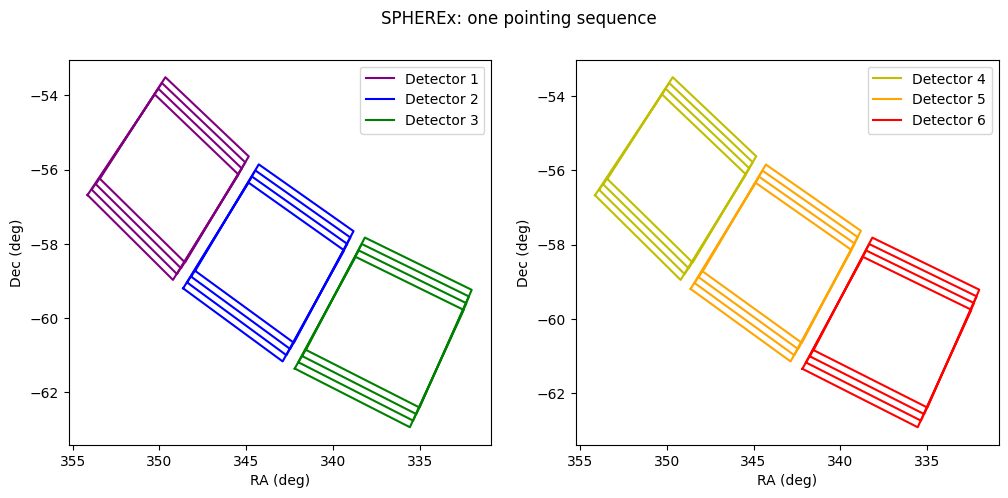

In [9]:
plt.figure(figsize=(12,5))
#for o in np.unique(T.obsid)[:20]:
leg1 = {}
leg2 = {}
for o in np.unique(T.expidn)[:24]:
    #I = np.flatnonzero(T.obsid == o)
    #plt.scatter(T.ra[I], T.dec[I], c=T.detector[I])
    #I = np.flatnonzero(T.expidn == o)
    plt.subplot(1,2,1)
    I = np.flatnonzero((T.expidn == o) * (T.detector <= 3))
    for i in I:
        rd = T.radec_corners[i,:].reshape((4,2))
        J = np.array([0,1,2,3,0])
        rd = rd[J,:]
        p = plt.plot(rd[:,0], rd[:,1], '-', color=detector_color[T.detector[i]])
        leg1['Detector %i' % T.detector[i]] = p

    plt.subplot(1,2,2)
    I = np.flatnonzero((T.expidn == o) * (T.detector > 3))
    for i in I:
        rd = T.radec_corners[i,:].reshape((4,2))
        J = np.array([0,1,2,3,0])
        rd = rd[J,:]
        p = plt.plot(rd[:,0], rd[:,1], '-', color=detector_color[T.detector[i]])
        leg2['Detector %i' % T.detector[i]] = p

ax = plt.axis()
for sp in [1,2]:
    plt.subplot(1,2,sp)
    plt.xlim(ax[1],ax[0])
    plt.xlabel('RA (deg)')
    plt.ylabel('Dec (deg)')
plt.subplot(1,2,1)
plt.legend(leg1)
#plt.title('Detectors 1-3')
plt.subplot(1,2,2)
plt.legend(leg2)
#plt.title('Detectors 4-6')
plt.suptitle('SPHEREx: one pointing sequence');
plt.savefig('seq.png')

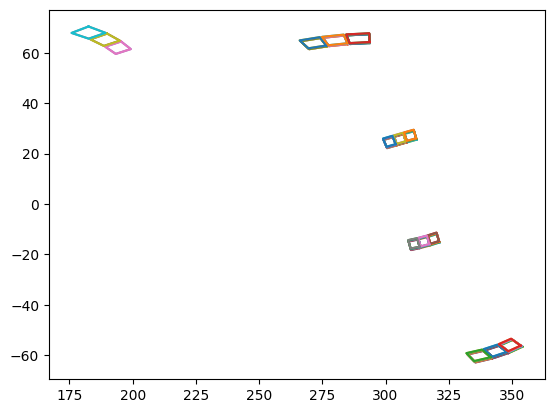

In [10]:
I = np.argsort(T.mjd)
for i in I[:100]:
    rd = T.radec_corners[i,:].reshape((4,2))
    J = np.array([0,1,2,3,0])
    rd = rd[J,:]
    plt.plot(rd[:,0], rd[:,1], '-')

In [11]:
import matplotlib

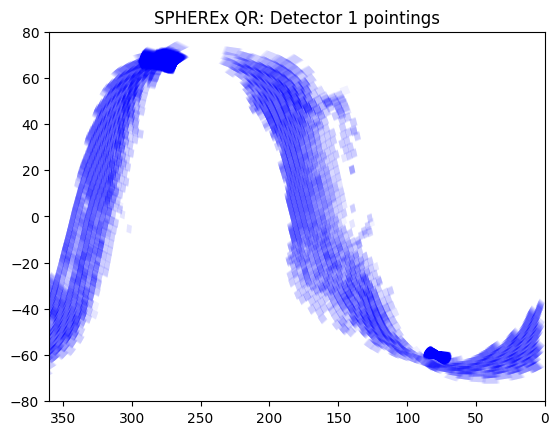

In [12]:
I = np.flatnonzero(T.detector == 1)
for i in I:
    rd = T.radec_corners[i,:].reshape((4,2))
    J = np.array([0,1,2,3,0])
    rd = rd[J,:]
    ra = rd[:,0]
    dec = rd[:,1]
    rawrap = (max(ra) - min(ra)) > 180
    if rawrap:
        ra[ra<180] += 360
    #p = plt.plot(ra, dec, '-', color='k', alpha=0.01)
    p = matplotlib.patches.Polygon(np.vstack((ra,dec)).T, ec='none', fc='b', alpha=0.05)
    ax = plt.gca()
    ax.add_artist(p)
plt.axis([360, 0, -80, +80])
plt.title('SPHEREx QR: Detector 1 pointings')
plt.savefig('detector1.png')

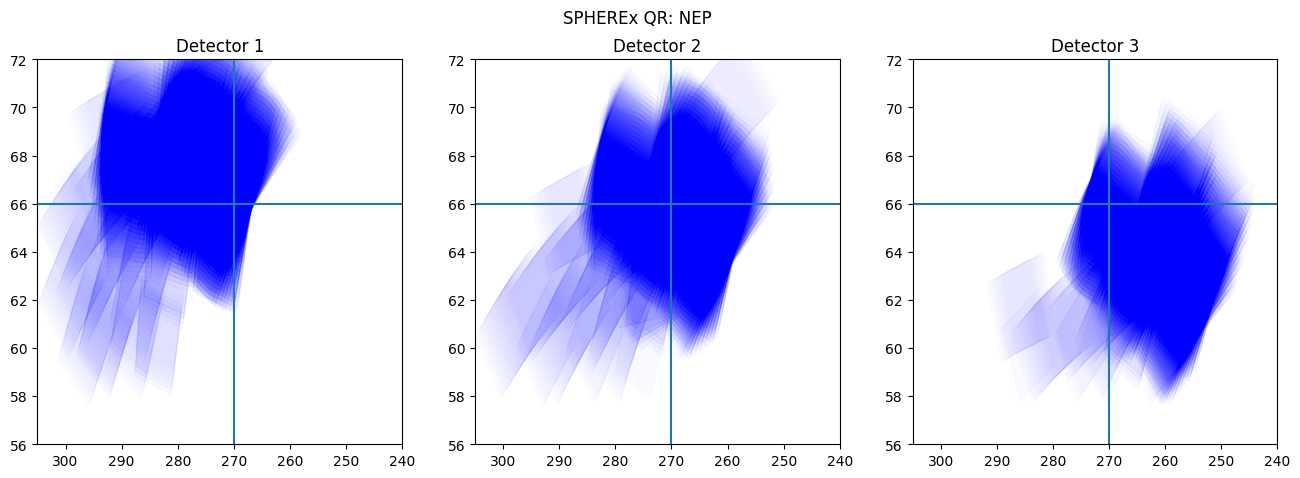

In [35]:
plt.figure(figsize=(16,5))
for det in [1,2,3]:
    plt.subplot(1,3,det)
    
    I = np.flatnonzero((T.detector == det) * (T.ra > 250) * (T.ra < 300) * (T.dec > 60))
    for i in I:
        rd = T.radec_corners[i,:].reshape((4,2))
        J = np.array([0,1,2,3,0])
        rd = rd[J,:]
        ra = rd[:,0]
        dec = rd[:,1]
        #p = plt.plot(ra, dec, '-', color='k', alpha=0.01)
        p = matplotlib.patches.Polygon(np.vstack((ra,dec)).T, ec='b', fc='b', alpha=0.01)
        ax = plt.gca()
        ax.add_artist(p)
    #plt.axis([360, 0, -80, +80])
    plt.title('Detector %i' % det)
    plt.axis([305, 240, 56, 72])
    plt.axhline(66)
    plt.axvline(270)
plt.suptitle('SPHEREx QR: NEP')
plt.savefig('detector1-nep.png')

In [98]:
I = np.flatnonzero((T.radec_corners[:,0] > 270) *
                   (T.radec_corners[:,4] < 270) *
                   (T.radec_corners[:,1] <  66) *
                   (T.radec_corners[:,5] >  66))
len(I)

756

In [167]:
#ra,dec = 270.0632, 66.5758
#ra,dec = 270.0298, 66.6150
#ra,dec = 269.9284, 66.5669
#ra,dec = 269.832069, 66.624648
#ra,dec = 270.0307, 66.6139
#ra,dec = 270.0301, 66.6146

# NEP -- target is selected by t_ra,t_dec below
ra,dec = 270.0, 66.561

In [168]:
I,jj,dd = match_radec(T.ra, T.dec, ra, dec, 3.)

In [169]:
len(I)

2652

In [170]:
T.about()

tabledata object with 86791 rows and 17 columns:
   cd11 (<class 'numpy.ndarray'>) shape (86791,) dtype >f8
   cd12 (<class 'numpy.ndarray'>) shape (86791,) dtype >f8
   cd21 (<class 'numpy.ndarray'>) shape (86791,) dtype >f8
   cd22 (<class 'numpy.ndarray'>) shape (86791,) dtype >f8
   dec (<class 'numpy.ndarray'>) shape (86791,) dtype >f8
   detector (<class 'numpy.ndarray'>) shape (86791,) dtype >f8
   expidn (<class 'numpy.ndarray'>) shape (86791,) dtype >i8
   exptime (<class 'numpy.ndarray'>) shape (86791,) dtype >f8
   filename (<class 'numpy.ndarray'>) shape (86791,) dtype <U114
   height (<class 'numpy.ndarray'>) shape (86791,) dtype >f8
   mjd (<class 'numpy.ndarray'>) shape (86791,) dtype >f8
   obsid (<class 'numpy.ndarray'>) shape (86791,) dtype <U17
   ra (<class 'numpy.ndarray'>) shape (86791,) dtype >f8
   radec_corners (<class 'numpy.ndarray'>) shape (86791, 8) dtype >f8
   sip (<class 'list'>) length 86791 
   wcs (<class 'list'>) length 86791 
   width (<class 'numpy

In [83]:
T.wcs = [None for i in range(len(T))]
crpix = 1020.5
for i in I:
    T.wcs[i] = Tan(T.ra[i], T.dec[i], crpix, crpix, T.cd11[i], T.cd12[i], T.cd21[i], T.cd22[i], float(T.width[i]), float(T.height[i]))

xx,yy = [],[]
for i in I:
    wcs = T.wcs[i]
    ok,x,y = wcs.radec2pixelxy(ra, dec)
    xx.append(x)
    yy.append(y)
xx = np.array(xx)
yy = np.array(yy)

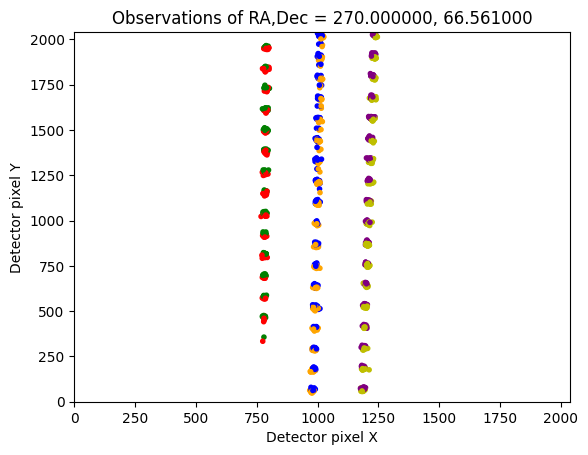

In [105]:
jitx = np.random.normal(size=len(xx))*5
jity = np.random.normal(size=len(xx))*5
plt.scatter(xx+jitx, yy+jity, c=[detector_color[d] for d in T.detector[I]], s=9);
plt.axis([0, 2040, 0, 2040])
plt.xlabel('Detector pixel X')
plt.ylabel('Detector pixel Y')
plt.title('Observations of RA,Dec = %f, %f' % (ra, dec));
plt.savefig('pixspace.png')

In [84]:
import astropy.io
import astropy.wcs

In [85]:
len(I)

2652

In [86]:
import time

## Read cutouts

In [205]:
cutouts_wavewcs = []
cutouts_wavewcs_values = []
cutouts_x0y0 = []
cutouts = []
cutouts_flag = []
cutouts_var = []
cutouts_zodi = []
cutouts_wcs = []

wave_nep = []

T.sip = [None for i in range(len(T))]
ikeep = []

t_fits = []
t_sip = []
t_wave = []
t_img = []

halfsize = 400

drop_xy = []
drop_xy2 = []
keep_xy = []

for i,fn in zip(I, T.filename[I]):
    # approx WCS
    wcs = T.wcs[i]
    ok,x,y = wcs.radec2pixelxy(ra, dec)

    ix = int(x-1)
    iy = int(y-1)
    h,w = wcs.shape
    h = int(h)
    w = int(w)
    # No overlap?
    if ix + halfsize < 1 or iy + halfsize < 1 or ix - halfsize >= w or iy - halfsize >= h:
        drop_xy.append((ix,iy))
        continue

    # Real WCS
    t0 = time.time()
    F = fitsio.FITS(fn)
    t1 = time.time()
    hdr = F['IMAGE'].read_header()
    #wcs = Sip(fn, 1)
    wcs = Sip(hdr)
    t2 = time.time()
    t_fits.append(t1-t0)
    t_sip.append(t2-t1)
    
    T.sip[i] = wcs
    ok,x,y = wcs.radec2pixelxy(ra, dec)
    ix = int(x-1)
    iy = int(y-1)
    if ix + halfsize < 1 or iy + halfsize < 1 or ix - halfsize >= w or iy - halfsize >= h:
        drop_xy2.append((ix,iy))
        continue

    keep_xy.append((ix,iy))
    ikeep.append(i)

    t0 = time.time()
    f = astropy.io.fits.open(fn)
    del f[1].header['A_ORDER']
    del f[1].header['B_ORDER']
    del f[1].header['AP_ORDER']
    del f[1].header['BP_ORDER']
    wavewcs_i = astropy.wcs.WCS(f[1].header, fobj=f, key='W')
    f.close()
    t1 = time.time()
    t_wave.append(t1-t0)

    cutouts_wavewcs.append(wavewcs_i)
    wave,_ = wavewcs_i.pixel_to_world(x-1, y-1)
    wave_nep.append(wave)

    x0 = max(0, ix-halfsize)
    y0 = max(0, iy-halfsize)
    x1 = min(w, ix+halfsize+1)
    y1 = min(h, iy+halfsize+1)
    print('.', end='')
    slc = slice(y0,y1), slice(x0,x1)
    t0 = time.time()
    cutouts.append(F['IMAGE'][slc])
    cutouts_flag.append(F['FLAGS'][slc])
    cutouts_var.append(F['VARIANCE'][slc])
    cutouts_zodi.append(F['ZODI'][slc])
    cutouts_x0y0.append((x0,y0))
    ww = F['WCS-WAVE'].read()
    cutouts_wavewcs_values.append(ww)
    #print('wavewcs:', ww, type(ww), ww.dtype)
    cutouts_wcs.append(wcs.get_subimage(x0, y0, x1-x0, y1-y0))
    t1 = time.time()
    t_img.append(t1-t0)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [206]:
cutouts_T = T[np.array(ikeep)]
len(cutouts_T), len(cutouts_wavewcs)

(2125, 2125)

In [207]:
Counter(cutouts_T.detector)

Counter({6.0: 226, 3.0: 233, 2.0: 443, 5.0: 419, 1.0: 406, 4.0: 398})

In [208]:
len(cutouts_wavewcs)

2125

In [209]:
sum(t_fits), sum(t_sip), sum(t_wave), sum(t_img)

(195.4830288887024, 260.7706298828125, 115.0356285572052, 55.13340377807617)

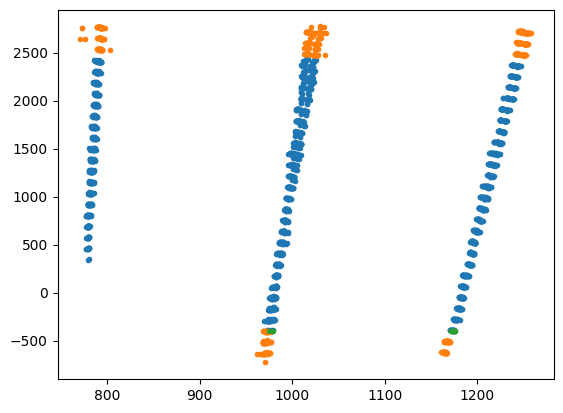

In [210]:
plt.plot([x for x,y in keep_xy], [y for x,y in keep_xy], '.');
plt.plot([x for x,y in drop_xy], [y for x,y in drop_xy], '.');
plt.plot([x for x,y in drop_xy2], [y for x,y in drop_xy2], '.');

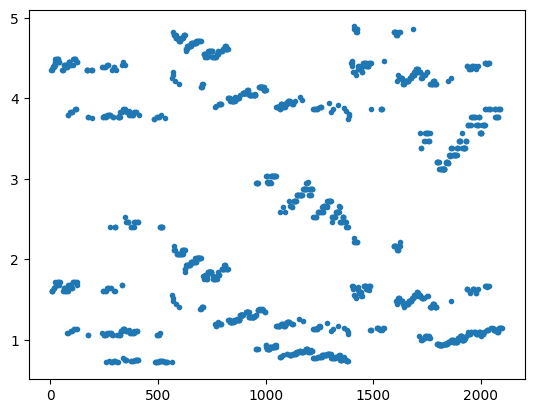

In [211]:
plt.plot([w.value for w in wave_nep], '.');

## Look at one exposure

In [92]:
for i,img in enumerate(cutouts):
    if img.shape == (801,801):
        break
i

566

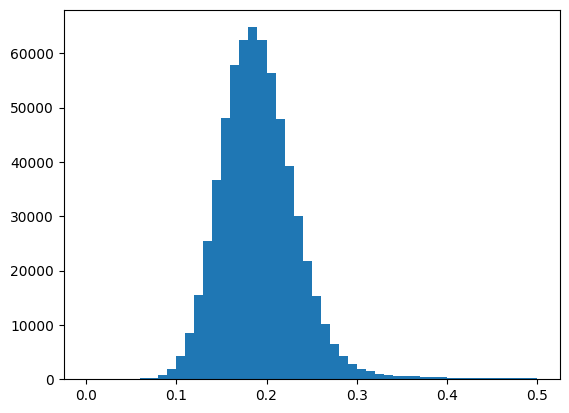

In [93]:
plt.hist(cutouts[i].ravel(), range=(0, +0.5), bins=50);

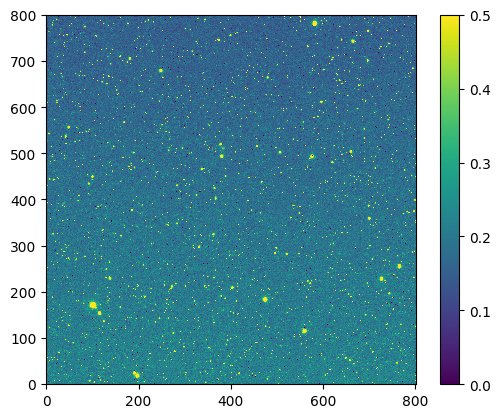

In [94]:
plt.imshow(cutouts[i], interpolation='nearest', origin='lower', vmin=0, vmax=0.5)
plt.colorbar();

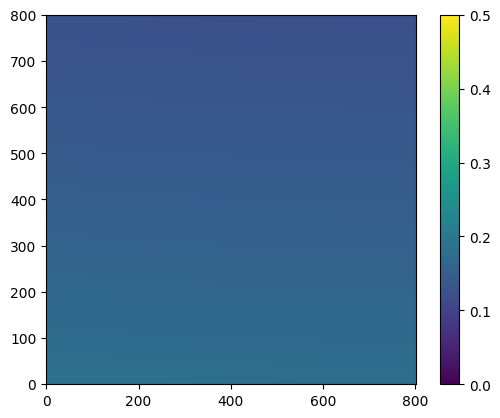

In [95]:
plt.imshow(cutouts_zodi[i], interpolation='nearest', origin='lower', vmin=0, vmax=0.5)
plt.colorbar();

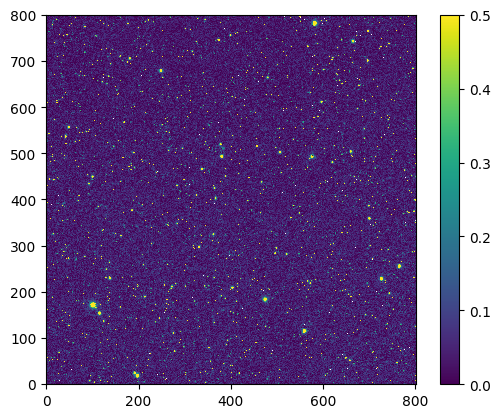

In [96]:
plt.imshow(cutouts[i] - cutouts_zodi[i], interpolation='nearest', origin='lower', vmin=0, vmax=0.5)
plt.colorbar();

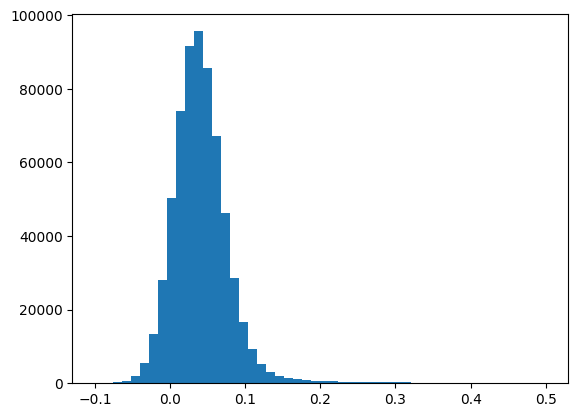

In [97]:
plt.hist((cutouts[i] - cutouts_zodi[i]).ravel(), range=(-0.1, 0.5), bins=50);

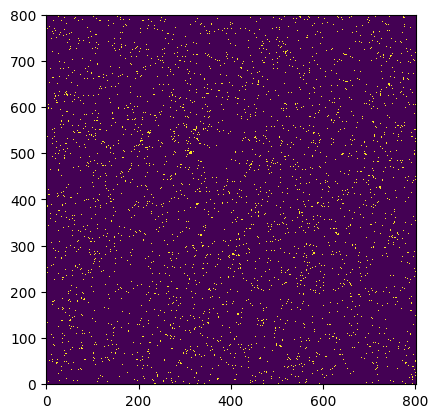

In [99]:
plt.imshow((cutouts_flag[i] & flag_mask) > 0, interpolation='nearest', origin='lower');

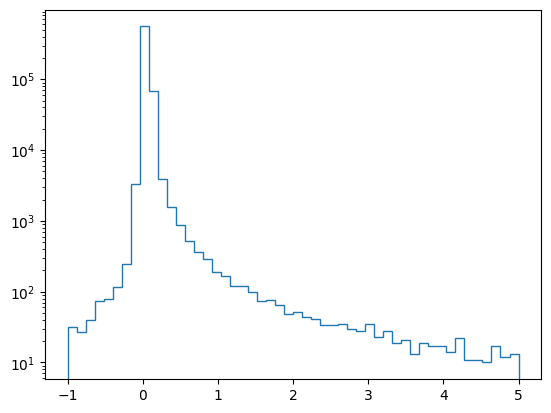

In [100]:
plt.hist((cutouts[i] - cutouts_zodi[i]).ravel(), range=(-1, 5), bins=50, log=True, histtype='step');

## Save pickle

In [212]:
f = open('/pscratch/sd/d/dstn/spherex-nep.pickle', 'wb')
pickle.dump(dict(cutouts_wcs=cutouts_wcs, cutouts=cutouts, cutouts_zodi=cutouts_zodi, cutouts_flag=cutouts_flag,
                 #cutouts_wavewcs=cutouts_wavewcs),
                 cutouts_T=cutouts_T, cutouts_wavewcs_values=cutouts_wavewcs_values, cutouts_x0y0=cutouts_x0y0),
            f)
f.close()

## Load pickle

In [16]:
f = open('/pscratch/sd/d/dstn/spherex-nep.pickle', 'rb')
X = pickle.load(f)

In [17]:
cutouts = X['cutouts']
cutouts_wcs = X['cutouts_wcs']
cutouts_zodi = X['cutouts_zodi']
cutouts_flag = X['cutouts_flag']
cutouts_T = X['cutouts_T']
cutouts_wavewcs_values = X['cutouts_wavewcs_values']
cutouts_x0y0 = X['cutouts_x0y0']

In [18]:
del X

In [19]:
import astropy.units as u

In [20]:
from scipy.interpolate import RegularGridInterpolator
class FakeWaveWCS(object):
    def __init__(self, xgrid, ygrid, gridvals):
        wavegrid  = gridvals[:,:,0]
        dwavegrid = gridvals[:,:,1]
        self.wavefunc = RegularGridInterpolator((xgrid, ygrid), wavegrid.T)
        self.dwavefunc = RegularGridInterpolator((xgrid, ygrid), dwavegrid.T)
    def pixel_to_world(self, x, y):
        w = self.wavefunc((x,y))
        w = w * u.um
        d = self.dwavefunc((x,y))
        d = d * u.um
        return w,d

In [21]:
cutouts_wavewcs = [FakeWaveWCS(v['X'][0,:], v['Y'][0,:], v['VALUES'][0, :,:,:]) for v in cutouts_wavewcs_values]

## Check wavewcs

In [104]:
vals = cutouts_wavewcs_values[0]
xgrid = vals['X'][0,:]
ygrid = vals['Y'][0,:]
wavegrid =  vals['VALUES'][0,:,:,0]
dwavegrid = vals['VALUES'][0,:,:,1]

wavewcs = FakeWaveWCS(xgrid, ygrid, vals['VALUES'][0,:,:,:])
wavewcs.pixel_to_world(x, y)

w 4.688889341304872


(<Quantity 4.68888934 um>, <Quantity 0.03668927 um>)

In [72]:
import astropy
import astropy.wcs

In [73]:
fn = cutouts_T.filename[0]

In [92]:
x,y = 1000., 1010.
f = astropy.io.fits.open(fn)
del f[1].header['A_ORDER']
del f[1].header['B_ORDER']
del f[1].header['AP_ORDER']
del f[1].header['BP_ORDER']
wavewcs_i = astropy.wcs.WCS(f[1].header, fobj=f, key='W')
f.close()
wave,_ = wavewcs_i.pixel_to_world(x-1, y-1)
wave

<SpectralCoord 4.68888934 um>

In [86]:
vals = cutouts_wavewcs_values[0]
xgrid = vals['X'][0,:]
ygrid = vals['Y'][0,:]
wavegrid =  vals['VALUES'][0,:,:,0]
dwavegrid = vals['VALUES'][0,:,:,1]

In [87]:
from scipy.interpolate import RegularGridInterpolator

In [95]:
wavefunc = RegularGridInterpolator((xgrid, ygrid), wavegrid.T)

In [96]:
wavefunc((1000., 1010.))

array(4.68888934)

## Look at single object

In [22]:
from astrometry.util.resample import resample_with_wcs

def show_one_object(t_ra, t_dec, get_all=False, max_wave=None):
    halfsize = 8
    t_size = 2*halfsize+1
    pixscale = 6./3600.
    target_wcs = Tan(t_ra, t_dec, t_size/2+0.5, t_size/2+0.5, -pixscale, 0., 0., +pixscale, t_size, t_size)

    wavelengths = []
    wavewidths = []
    ii = []
    xx,yy = [],[]
    dd = []
    for i,(wcs,img,zodi,flags,wwcs,(x0,y0)) in enumerate(zip(cutouts_wcs, cutouts, cutouts_zodi, cutouts_flag, cutouts_wavewcs, cutouts_x0y0)):
        ok,x,y = wcs.radec2pixelxy(t_ra, t_dec)
        xx.append(x)
        yy.append(y)
        dd.append(cutouts_T.detector[i])
        h,w = wcs.shape
        ix = int(x-1)
        iy = int(y-1)
        if ix < halfsize or iy < halfsize or ix+halfsize >= w or iy+halfsize >= h:
            continue
        wave,wavewidth = wwcs.pixel_to_world(x0 + x-1, y0 + y-1)
        wavelengths.append(wave.value)
        #print('dwave:', wavewidth)
        wavewidths.append(wavewidth.value)
        ii.append(i)
    J = np.argsort(wavelengths)
    ii = np.array(ii)[J]
    wavelengths = np.array(wavelengths)[J]
    wavewidths = np.array(wavewidths)[J]

    #plt.clf()
    #plt.scatter(xx, yy, color=[detector_color[d] for d in dd])
    #plt.show()

    #plt.clf()
    #plt.plot(wavelengths, '.')
    #plt.show()
    
    plt.figure(figsize=(13,9))

    rtn = []

    NR,NC = 8, 14
    
    k = 0
    last_wave = 0
    for j,(i,wave, dwave) in enumerate(zip(ii, wavelengths, wavewidths)):
        if not get_all:
            if k >= NR*NC:
                break
            if wave - last_wave < 0.01:
                continue
            last_wave = wave
        if get_all and max_wave is not None:
            if wave > max_wave:
                break
        wcs = cutouts_wcs[i]
        ok,x,y = wcs.radec2pixelxy(t_ra, t_dec)
        h,w = wcs.shape
        ix = int(x-1)
        iy = int(y-1)
        y0 = iy - halfsize
        x0 = ix - halfsize
        sz = t_size
        sub_wcs = wcs.get_subimage(x0, y0, sz, sz)
        sh,sw = sub_wcs.shape
        slc = slice(y0, y0+sz), slice(x0, x0+sz)

        mflag = ((cutouts_flag[i] & flag_mask_source) == 0) * ((cutouts_flag[i] & flag_mask) == 0)
        pix = (cutouts[i] - cutouts_zodi[i])[mflag]
        if len(pix) == 0:
            print('No unmasked pix')
            continue
        #print('Flags ok:', Counter(mflag.ravel()))
        #print('cutouts:', np.median(cutouts[i][mflag])) 
        #print('zodi:', np.median(cutouts_zodi[i][mflag]))
        pix = pix[np.isfinite(pix)]
        if len(pix) == 0:
            print('No finite pix')
            continue
        med = np.median(pix)
        #print('Estimating median on', len(pix), 'pixels')
        c = cutouts[i][slc] - cutouts_zodi[i][slc] - med
        f = (cutouts_flag[i][slc].astype(np.uint32) & flag_mask)
        c[f != 0] = 0.

        try:
            yo,xo,yi,xi,r = resample_with_wcs(target_wcs, sub_wcs, [c])
        except:
            import traceback
            traceback.print_exc()
            continue
        rimg = np.zeros(target_wcs.shape)
        rimg[yo,xo] = r[0]

        rtn.append((rimg, wave, dwave))

        if get_all:
            if k >= NR*NC:
                continue
            if wave - last_wave < 0.01:
                continue
            last_wave = wave

        plt.subplot(NR,NC, k+1)
        k += 1
        dmin,dmax = -0.1, +0.5
        plt.imshow(rimg, interpolation='nearest', origin='lower', vmin=dmin, vmax=dmax)
        plt.xticks([]); plt.yticks([])
        plt.title('%.3f' % wave, fontsize=8)
    
    plt.subplots_adjust(wspace=0.05, hspace=0.25)
    return rtn

In [23]:
#t_ra,t_dec = 271.8908, 66.4950
t_ra, t_dec = 271.2313, 66.5668
#t_ra, t_dec = 269.3949, 66.1843
#t_ra,t_dec = 269.9801, 66.5656

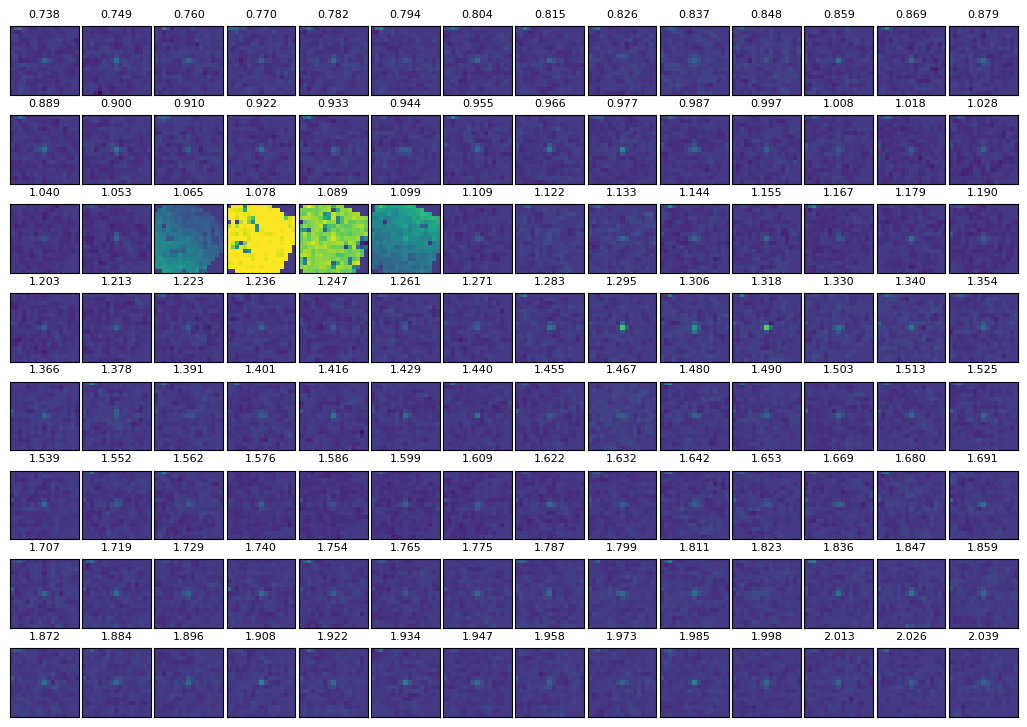

In [24]:
R = show_one_object(t_ra, t_dec)

In [25]:
from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry

In [26]:
def phot_one_object(imgs, waves):
    flux = np.zeros(len(imgs))
    flux_bg = np.zeros(len(imgs))
    flux_med = np.zeros(len(imgs))
    for i,(im,wave) in enumerate(zip(imgs, waves)):
        h,w = im.shape
        r_src = 2.
        r_bg_inner = 4
        r_bg_outer = 7
        # center
        cx,cy = w//2, h//2
        aper = CircularAperture((cx, cy), r_src)
        p = aperture_photometry(im, aper)
        f = p.field('aperture_sum')[0]
        # annulus
        aper = CircularAnnulus((cx, cy), r_bg_inner, r_bg_outer)
        p = aperture_photometry(im, aper)
        f_bg = p.field('aperture_sum')[0]
        flux[i] = f
        f_bg *= (r_src**2 / (r_bg_outer**2 - r_bg_inner**2))
        flux_bg[i] = f_bg
        med = np.median(im)
        flux_med[i] = np.pi * r_src**2 * med
    return flux, flux_bg, flux_med

In [27]:
def plot_phot_one_object(imgs, waves, mx=None):
    flux, flux_bg, flux_med = phot_one_object(imgs, waves);
    if mx is None:
        mx = 1.
    mn = -mx
    plt.plot(waves, np.clip(flux - flux_med, mn, mx), '.', label='flux - med');#, lw=3, alpha=0.3);    
    yl,yh = plt.ylim()
    plt.plot(waves, np.clip(flux, mn, mx), '.-', label='flux', alpha=0.1)
    #plt.plot(waves, np.clip(flux - flux_bg, mn, mx), '.-', label='flux - bg');
    plt.ylim(yl,yh)

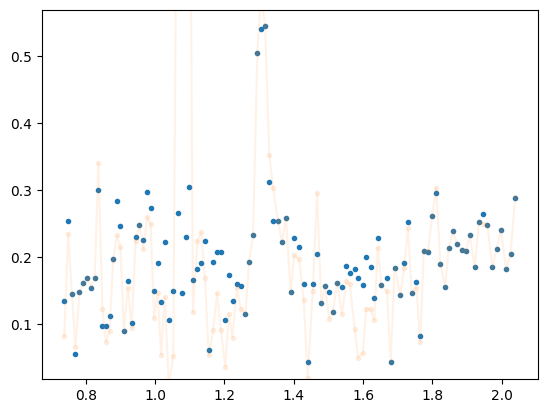

In [29]:
waves = [wave for _,wave,_ in R]
imgs = [img for img,_,_ in R]
plot_phot_one_object(imgs, waves);

## Finding objects in DESI spectroscopy

In [33]:
from astrometry.util.util import *
from astrometry.util.starutil_numpy import *

In [34]:
ra,dec = 270., 66.56
Nside = 64

# Find healpixes for NEP +- 0.5 deg
step = 0.5
nsteps = 2
hps = set()
for dr in range(-nsteps, nsteps+1):
    for dd in range(-nsteps, nsteps+1):
        hp = radecdegtohealpix(ra + dr*step * np.cos(np.deg2rad(dec)), dec + dd*step, Nside)
        hps.add(hp)
print(hps)
hps = [healpix_xy_to_nested(hp, Nside) for hp in hps]
hps.sort()
print(hps)

{12256, 12257, 14463, 12255, 14335, 14399, 12254, 14271}
[10237, 10239, 11605, 11607, 15358, 15359, 16042, 16043]


In [35]:
fns = ['/global/cfs/cdirs/desi/spectro/redux/loa/healpix/main/bright/%i/%i/redrock-main-bright-%i.fits' % (hp//100, hp, hp)
#fns = ['/global/cfs/cdirs/desi/spectro/redux/loa/healpix/main/dark/%i/%i/redrock-main-dark-%i.fits' % (hp//100, hp, hp)
       for hp in hps]

In [36]:
import os

In [37]:
TT = []
for fn,healpix in zip(fns, hps):
    if not os.path.exists(fn):
        print('Does not exist:', fn)
        continue
    D = fits_table(fn)
    D.healpix = np.zeros(len(D), int)+healpix
    # fibermap
    fm = fits_table(fn, hdu=2)
    assert(np.all(D.targetid == fm.targetid))
    fm.delete_column('targetid')
    D.add_columns_from(fm)
    TT.append(D)
D = merge_tables(TT)

In [38]:
d = degrees_between(D.target_ra, D.target_dec, ra, dec)
I = np.flatnonzero(d < 1)
D.cut(I)

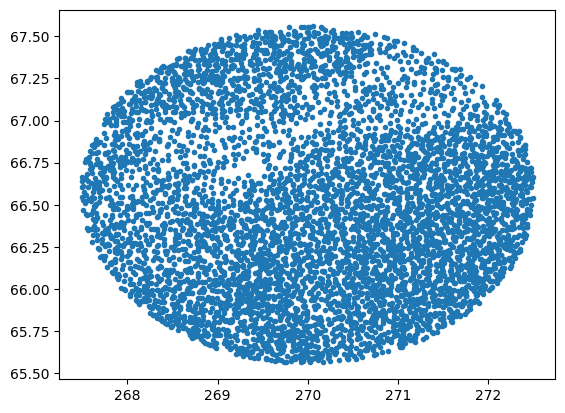

In [39]:
plt.plot(D.target_ra, D.target_dec, '.');

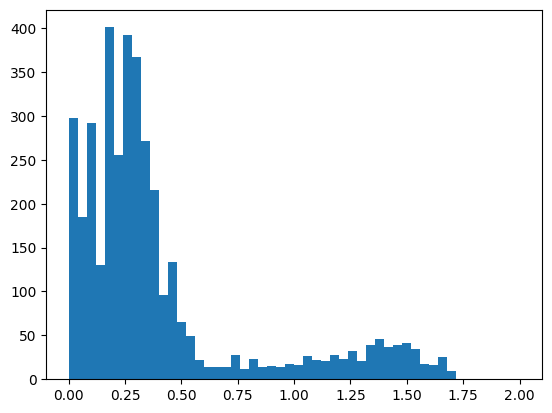

In [40]:
plt.hist(D.z, range=(0,2), bins=50);

In [41]:
Counter(D.spectype)

Counter({'GALAXY': 3663, 'STAR': 1997, 'QSO': 63})

/tmp/ipykernel_663414/2907010275.py:5: RuntimeWarning: divide by zero encountered in log10
  D.fibermag_g = -2.5 * (np.log10(D.fiberflux_g) - 9)
/tmp/ipykernel_663414/2907010275.py:5: RuntimeWarning: invalid value encountered in log10
  D.fibermag_g = -2.5 * (np.log10(D.fiberflux_g) - 9)
/tmp/ipykernel_663414/2907010275.py:6: RuntimeWarning: divide by zero encountered in log10
  D.fibermag_r = -2.5 * (np.log10(D.fiberflux_r) - 9)
/tmp/ipykernel_663414/2907010275.py:6: RuntimeWarning: invalid value encountered in log10
  D.fibermag_r = -2.5 * (np.log10(D.fiberflux_r) - 9)
/tmp/ipykernel_663414/2907010275.py:7: RuntimeWarning: divide by zero encountered in log10
  D.fibermag_z = -2.5 * (np.log10(D.fiberflux_z) - 9)
/tmp/ipykernel_663414/2907010275.py:7: RuntimeWarning: invalid value encountered in log10
  D.fibermag_z = -2.5 * (np.log10(D.fiberflux_z) - 9)


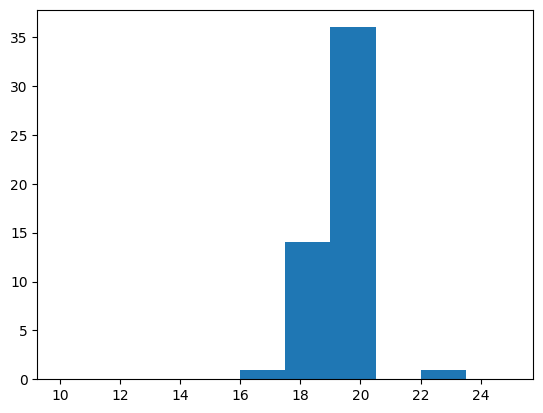

In [42]:
I = np.flatnonzero(D.spectype == 'QSO')
#I = np.flatnonzero(D.spectype == 'GALAXY')
#I = np.flatnonzero((D.spectype == 'GALAXY') * (D.z > 1))
#I = np.flatnonzero((D.spectype == 'STAR') * (D.subtype == 'G'))
D.fibermag_g = -2.5 * (np.log10(D.fiberflux_g) - 9)
D.fibermag_r = -2.5 * (np.log10(D.fiberflux_r) - 9)
D.fibermag_z = -2.5 * (np.log10(D.fiberflux_z) - 9)
plt.hist(D.fibermag_z[I], range=(10,25), bins=10);

In [43]:
i = I[np.argsort(D.fibermag_z[I])[5]]

In [44]:
print(D.fibermag_z[i], D.z[i])
t_ra,t_dec = D.target_ra[i], D.target_dec[i]

18.319248 0.2615866712554263


In [45]:
'https://legacysurvey.org/viewer-desi/?ra=%.4f&dec=%.4f&zoom=13&desi-spec-daily' % (t_ra, t_dec)

'https://legacysurvey.org/viewer-desi/?ra=271.8908&dec=66.4950&zoom=13&desi-spec-daily'

In [46]:
'%.4f, %.4f' % (t_ra, t_dec)

'271.8908, 66.4950'

In [47]:
# ok:
#269.132698, 66.418881
#271.8908, 66.4950


## Show DESI object

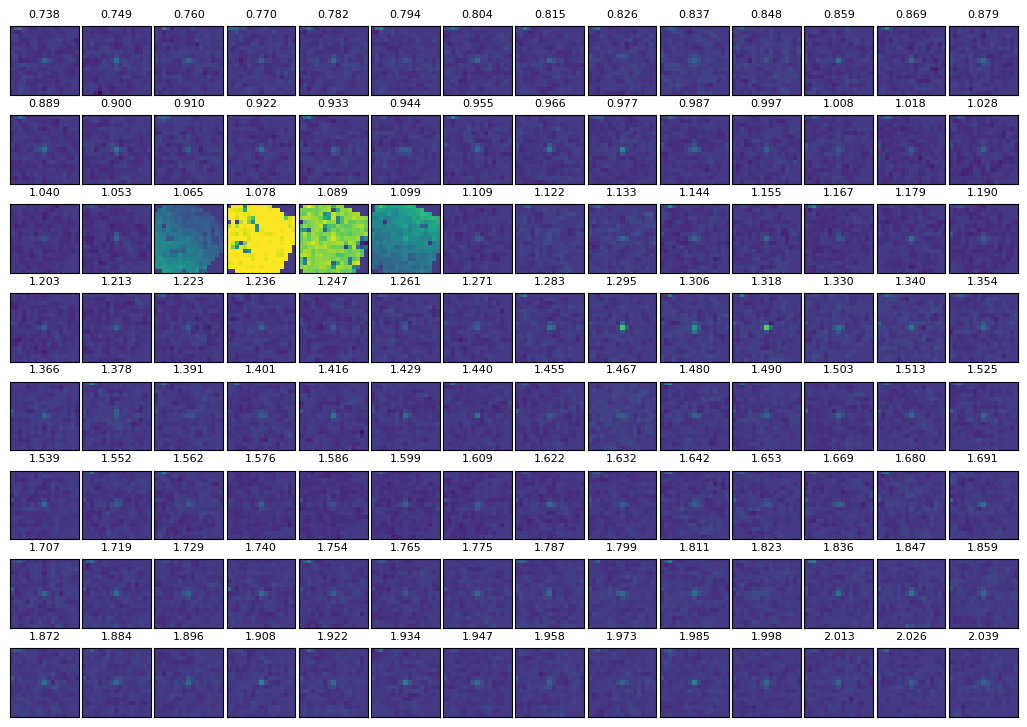

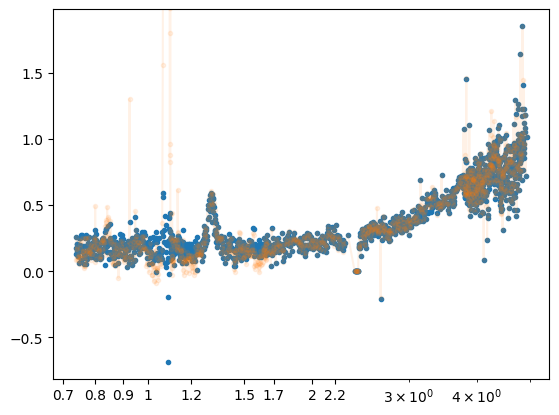

In [30]:
R = show_one_object(t_ra, t_dec, get_all=True)
plt.show()
waves = [wave for _,wave,_ in R]
imgs = [img for img,_,_ in R]
plt.clf()
plot_phot_one_object(imgs, waves, mx=10.);
plt.xscale('log')
tt = [0.7, 0.8, 0.9, 1.0, 1.2, 1.5, 1.7, 2.0, 2.2]
plt.xticks(tt, ['%g'%t for t in tt]);

In [48]:
hp = D.healpix[i]
co_fn = '/global/cfs/cdirs/desi/spectro/redux/loa/healpix/main/bright/%i/%i/coadd-main-bright-%i.fits' % (hp//100, hp, hp)
targetid = D.targetid[i]

fibermap = fits_table(co_fn)
j = np.flatnonzero(fibermap.targetid == targetid)
assert(len(j) == 1)
j = j[0]
F = fitsio.FITS(co_fn)
ra = fibermap.target_ra[j]
dec = fibermap.target_dec[j]
b_wave = F['B_WAVELENGTH'].read()
b_flux = F['B_FLUX'].read()[j, :]
b_ivar = F['B_IVAR'].read()[j, :]
r_wave = F['R_WAVELENGTH'].read()
r_flux = F['R_FLUX'].read()[j, :]
r_ivar = F['R_IVAR'].read()[j, :]
z_wave = F['Z_WAVELENGTH'].read()
z_flux = F['Z_FLUX'].read()[j, :]
z_ivar = F['Z_IVAR'].read()[j, :]

In [49]:
tt = '%s at z=%.3f: RA,Dec = (%.4f, %.4f)  Fibermag grz (%.1f, %.1f, %.1f)' % (D.spectype[i], D.z[i], t_ra, t_dec,
                                                                              D.fibermag_g[i], D.fibermag_r[i], D.fibermag_z[i])

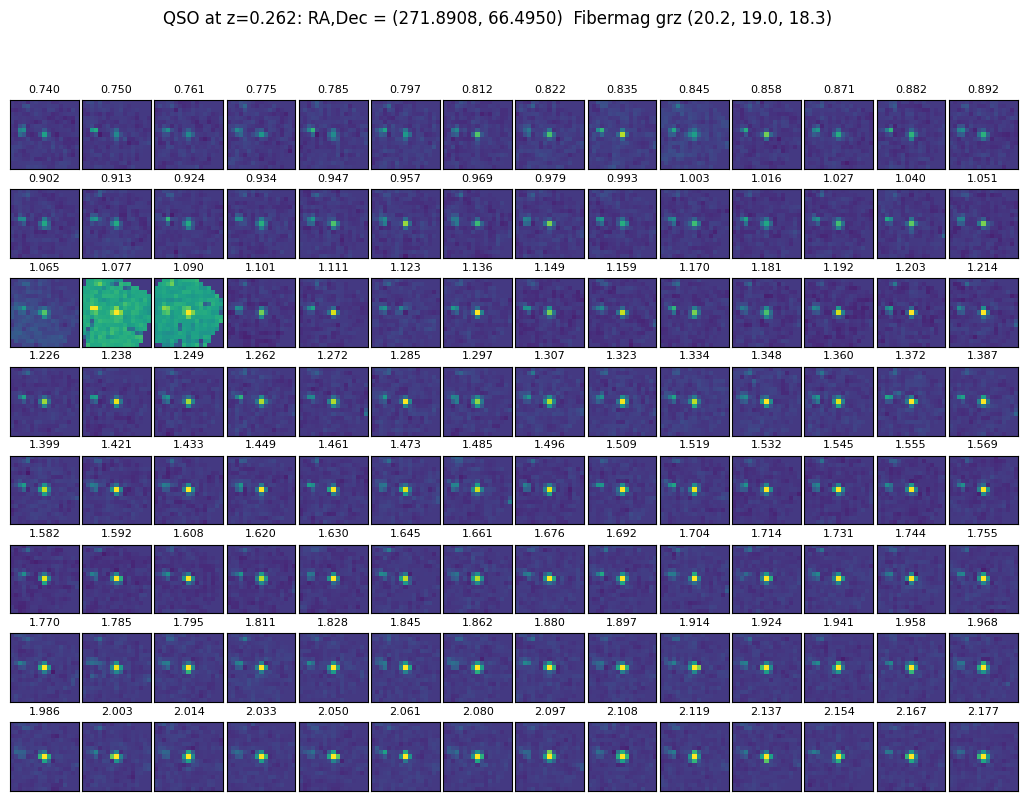

In [50]:
R = show_one_object(t_ra, t_dec, get_all=True, max_wave=2.3)
plt.suptitle(tt)
plt.savefig('spherex-stamps.png')

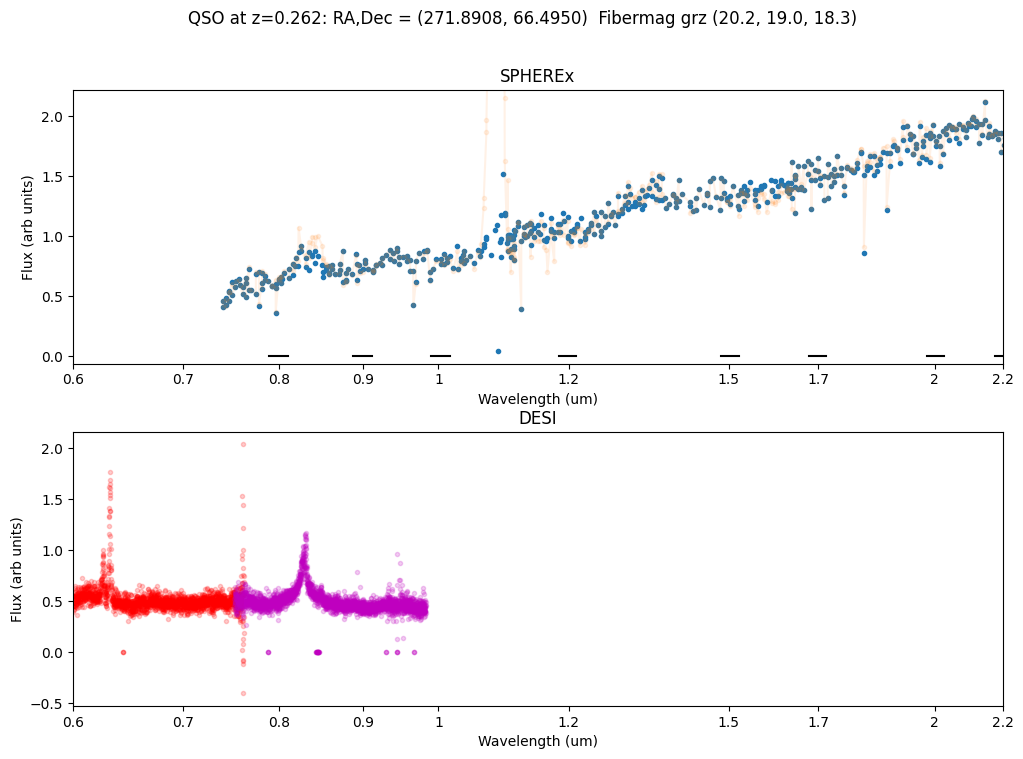

In [51]:
waves = [wave for _,wave,_ in R]
dwaves = [dwave for _,_,dwave in R]
imgs = [img for img,_,_ in R]
plt.figure(figsize=(12,8))
plt.subplot(2,1,1)
plot_phot_one_object(imgs, waves, mx=10.);
plt.xscale('log')
tix = [0.6, 0.7, 0.8, 0.9, 1.0, 1.2, 1.5, 1.7, 2.0, 2.2]
plt.xticks(tix, ['%g'%t for t in tix]);
plt.xlim(0.6, 2.2)
plt.xlabel('Wavelength (um)')
plt.ylabel('Flux (arb units)')
plt.title('SPHEREx')

for t in tix[2:]:
    j = np.argmin(np.abs(t - np.array(waves)))
    w = waves[j]
    dw = dwaves[j]
    plt.plot([w-dw/2, w+dw/2], [0, 0], 'k-')

plt.subplot(2,1,2)
#plt.plot(b_wave / 1e4, b_flux / 20., 'b.');
plt.plot(r_wave / 1e4, r_flux / 20., 'r.', alpha=0.2);
plt.plot(z_wave / 1e4, z_flux / 20., 'm.', alpha=0.2);
plt.xscale('log')
plt.xticks(tix, ['%g'%t for t in tix]);
plt.xlim(0.6, 2.2)
plt.title('DESI')
plt.xlabel('Wavelength (um)')
plt.ylabel('Flux (arb units)')
plt.suptitle(tt)
plt.subplots_adjust(hspace=0.25)
plt.savefig('desi-spherex.png');

In [61]:
z_flux[0]

8.946729

In [65]:
pix_per_sr = (np.rad2deg(1.) * 3600 / 6)**2
pix_per_sr

1181810286.0042276

In [67]:
0.5 * 3e8 / (1e-6)**2 / 1e10 / pix_per_sr

12.69239249111286

## here

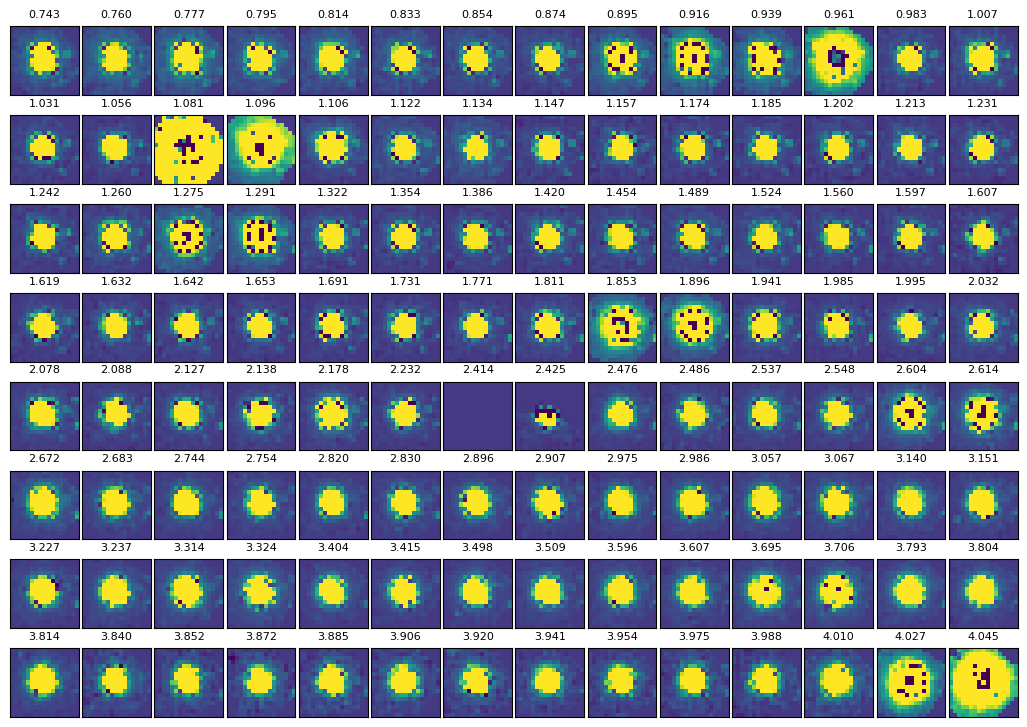

In [119]:
R = show_one_object(269.6381, 66.6322, get_all=True)

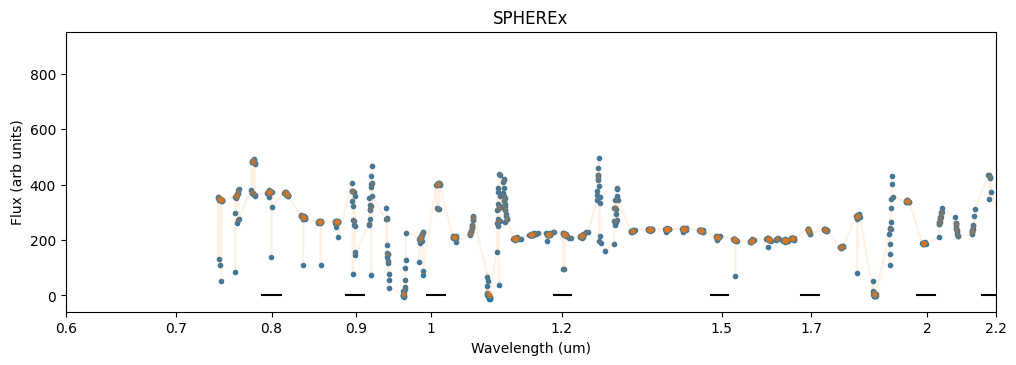

In [126]:
waves = [wave for _,wave,_ in R]
dwaves = [dwave for _,_,dwave in R]
imgs = [img for img,_,_ in R]
plt.figure(figsize=(12,8))
plt.subplot(2,1,1)
plot_phot_one_object(imgs, waves, mx=1000.);
plt.xscale('log')
tix = [0.6, 0.7, 0.8, 0.9, 1.0, 1.2, 1.5, 1.7, 2.0, 2.2]
plt.xticks(tix, ['%g'%t for t in tix]);
plt.xlim(0.6, 2.2)
plt.xlabel('Wavelength (um)')
plt.ylabel('Flux (arb units)')
plt.title('SPHEREx')

for t in tix[2:]:
    j = np.argmin(np.abs(t - np.array(waves)))
    w = waves[j]
    dw = dwaves[j]
    plt.plot([w-dw/2, w+dw/2], [0, 0], 'k-')


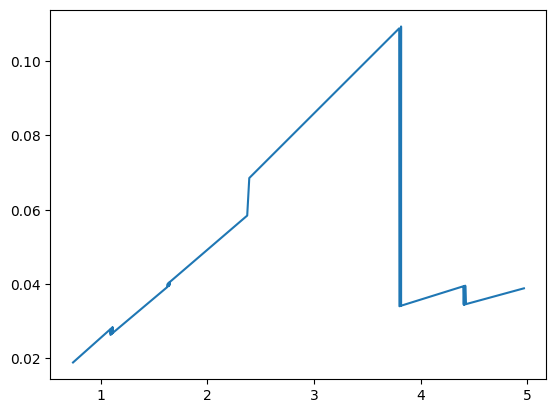

In [644]:
plt.plot(waves, dwaves);

In [636]:
url = 'http://www.legacysurvey.org/viewer/cutout.jpg?ra=%f&dec=%f&layer=ls-dr10-grz&pixscale=1&size=%i' % (t_ra, t_dec, 6.*t_size)
from IPython.core.display import HTML
HTML('<img src="%s">' % url)

In [638]:
url = 'http://www.legacysurvey.org/viewer/cutout.jpg?ra=%f&dec=%f&layer=ls-dr10-grz&pixscale=0.262&size=300' % (t_ra, t_dec)
from IPython.core.display import HTML
print(url)
HTML('<img src="%s">' % url)

http://www.legacysurvey.org/viewer/cutout.jpg?ra=271.890841&dec=66.494950&layer=ls-dr10-grz&pixscale=0.262&size=300


In [320]:
url = 'http://www.legacysurvey.org/viewer/cutout.jpg?ra=%f&dec=%f&layer=ls-dr10-grz&pixscale=1&size=%i' % (t_ra, t_dec, 6.*t_size)
from IPython.core.display import HTML
HTML('<img src="%s">' % url)

In [299]:
url = 'http://www.legacysurvey.org/viewer/cutout.jpg?ra=%f&dec=%f&layer=ls-dr10-grz&pixscale=1&size=%i' % (ra, dec, 6 * cw)
from IPython.core.display import HTML
HTML('<img src="%s">' % url)

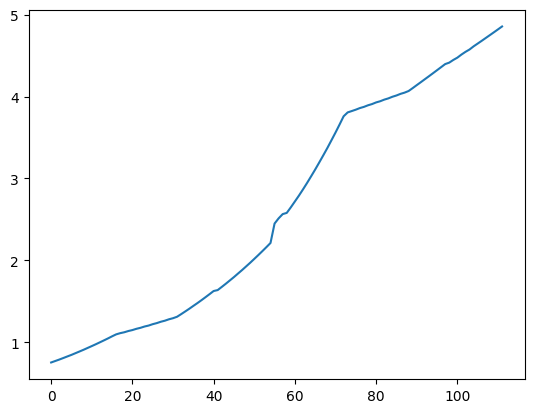

In [222]:
plt.plot([w for w,c in keep])

In [83]:
I = np.flatnonzero(T.detector == 1)
I = I[np.argsort(T.mjd[I])]
dists = np.zeros(len(I)-1)
for j,(i0,i1) in enumerate(zip(I, I[1:])):
    dists[j] = arcsec_between(T.ra[i0], T.dec[i0], T.ra[i1], T.dec[i1])

In [84]:
len(I)

5442

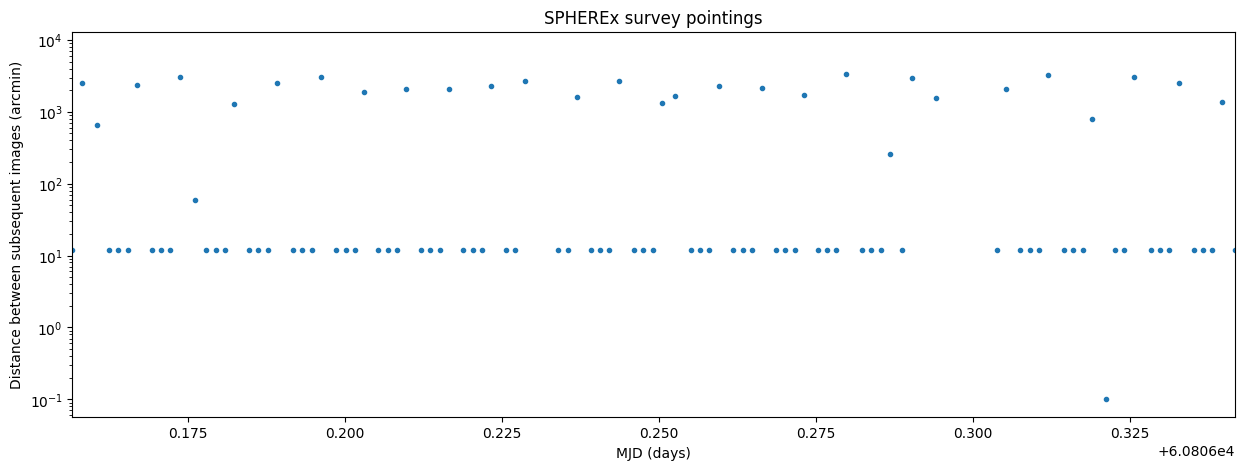

In [104]:
plt.figure(figsize=(15,5))
plt.plot(T.mjd[I[:-1]], np.clip(dists/60., 0.1, 1e4), '.')
#         np.minimum(3600, dists), '-');
plt.yscale('log')
plt.xlim(T.mjd[I[5000]], T.mjd[I[5100]]);
plt.ylabel('Distance between subsequent images (arcmin)')
plt.xlabel('MJD (days)')
plt.title('SPHEREx survey pointings')
plt.savefig('pointings.png');

## Old code for a single object

In [24]:
J = np.argsort([w.value for w,_ in wavelength])

In [25]:
keep = []
wave_last = 0.70
for j in J:
    w = wavelength[j][0].value
    c = cutouts[j]
    if c is None:
        continue
    if w - wave_last < 0.01:
        #print('Skipping', w)
        continue
    keep.append((w, c, cutout_wcs[j]))
    #plt.imshow(c)
    #plt.title('%.3f um' % w)
    #plt.show()
    wave_last = w
print(len(keep))

122


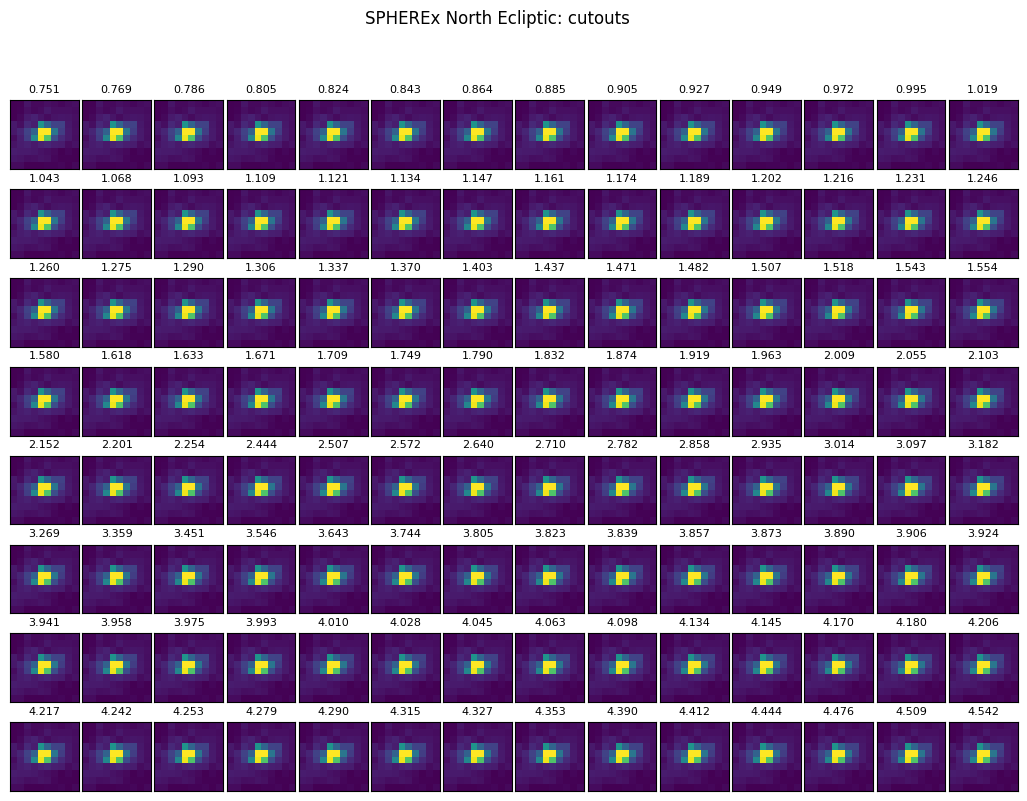

In [84]:
from astrometry.util.util import Tan
from astrometry.util.resample import resample_with_wcs
pixscale = 6./3600.
sz = halfsize*2+1.
#
#t_ra, t_dec = 270.0632, 66.5758
#t_ra, t_dec = 270.1510, 66.6168

#t_ra, t_dec = 270.028051, 66.649970

#t_ra, t_dec = 270.0301, 66.6146

t_size = 10
target_wcs = Tan(t_ra, t_dec, t_size/2+0.5, t_size/2+0.5, -pixscale, 0., 0., +pixscale, t_size, t_size)

plt.figure(figsize=(13,9))
for i,(w,c,c_wcs) in enumerate(keep):
    if i >= 8*14:
        break
    plt.subplot(8, 14, i+1)
    pix = c.ravel()
    pix = pix[np.isfinite(pix)]
    lo,med,hi = np.percentile(pix, [25, 50, 98])
    #print('pct', np.percentile(c.ravel(), [25, 50, 75]))

    try:
        yo,xo,yi,xi,r = resample_with_wcs(target_wcs, c_wcs, [c])
    except:
        pass

    rimg = np.zeros(target_wcs.shape)
    rimg[yo,xo] = r[0]
    # TRIM pix off left/right/top/bottom.
    # from above, total size should be 51
    #trim = 20
    #trim = 20
    #c = c[trim:-trim, trim:-trim]
    #ch,cw = c.shape

    #print('wave', w, 'hi-med:', hi-med)
    #plt.imshow(c, vmin=lo, vmax=hi + (hi-med))
    #plt.imshow(c, vmin=med-0.1, vmax=med+3.0)
    med = np.median(rimg)
    #print('rimg min', rimg.min(), 'max', rimg.max(), 'med', med)
    dmin,dmax = -0.1, +2.0
    #dmin,dmax = -0.05, +0.1
    plt.imshow(rimg, interpolation='nearest', origin='lower', vmin=med+dmin, vmax=med+dmax)
    plt.xticks([]); plt.yticks([])
    plt.title('%.3f' % w, fontsize=8)
plt.subplots_adjust(wspace=0.05, hspace=0.25)
plt.suptitle('SPHEREx North Ecliptic: cutouts')
plt.savefig('nep-cutouts.png')

In [33]:
url = 'http://www.legacysurvey.org/viewer/cutout.jpg?ra=%f&dec=%f&layer=ls-dr10-grz&pixscale=0.262&size=%i' % (t_ra, t_dec, int(6*t_size/0.262))
from IPython.core.display import HTML
HTML('<img src="%s">' % url)

In [29]:
t_ra, t_dec = 270.028051, 66.649970

In [30]:
url = 'http://www.legacysurvey.org/viewer/cutout.jpg?ra=%f&dec=%f&layer=ls-dr10-grz&pixscale=0.262&size=%i' % (t_ra, t_dec, int(6*t_size/0.262))
from IPython.core.display import HTML
HTML('<img src="%s">' % url)

In [ ]:
# https://www.legacysurvey.org/viewer/desi-spectrum/dr1/targetid39633458737187040